In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('f1_2019_to_2022_all_drivers_all_data.csv',low_memory=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82418 entries, 0 to 82417
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                82418 non-null  object 
 1   Driver              82418 non-null  object 
 2   DriverNumber        82418 non-null  int64  
 3   LapTime             80808 non-null  object 
 4   LapNumber           82418 non-null  float64
 5   Stint               82418 non-null  float64
 6   PitOutTime          2660 non-null   object 
 7   PitInTime           2758 non-null   object 
 8   Sector1Time         80613 non-null  object 
 9   Sector2Time         82252 non-null  object 
 10  Sector3Time         82186 non-null  object 
 11  Sector1SessionTime  80415 non-null  object 
 12  Sector2SessionTime  82252 non-null  object 
 13  Sector3SessionTime  82186 non-null  object 
 14  SpeedI1             70615 non-null  float64
 15  SpeedI2             82206 non-null  float64
 16  Spee

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('f1_2019_to_2022_all_drivers_all_data.csv', low_memory=False)

# Convert 'LapTime' and sector times to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Handle missing values for sector times and speed features
# You may need to keep the original 'Driver' and 'Circuit' for grouping before encoding
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Encode Rainfall, FreshTyre, IsAccurate, and IsPersonalBest to integer
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Drop columns not related to lap time prediction, Sector times are deleted since it is Laptime
columns_to_drop = ['Time', 'LapStartTime', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated','IsPersonalBest']

df.drop(columns=columns_to_drop, inplace=True)

# Remove outliers based on 'LapTime'
Q1 = df['LapTime'].quantile(0.25)
Q3 = df['LapTime'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['LapTime'] >= lower_bound) & (df['LapTime'] <= upper_bound)]


# Feature Engineering: Weather Condition Aggregates, Track Characteristics, etc.
# Example: Cumulative rainfall
df['CumulativeRainfall'] = df.groupby(['Original_Circuit'])['Rainfall'].cumsum()

# Weather condition changes
df['TrackTemp'] = df['TrackTemp'].diff().fillna(0)
df['RainfallChange'] = df['Rainfall'].diff().fillna(0)

# Cumulative Rainfall
df['CumulativeRainfall'] = df.groupby(['Year', 'DriverNumber'])['Rainfall'].cumsum()

# Speed Changes
df['SpeedI1Change'] = df['SpeedI1'].diff().fillna(0)

# Tyre Age Interaction with TrackTemp
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']

# Relative Position Change
df['PositionChange'] = df['Position'].diff().fillna(0).abs()

# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Circuit', 'Compound', 'Team'])

# Separate features and target
X = df.drop(['LapTime'], axis=1)
y = df['LapTime']

# Standardize numeric features
numeric_features = ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed']


scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])



print(X.info(verbose=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79034 entries, 0 to 82417
Data columns (total 113 columns):
 #    Column                               Dtype  
---   ------                               -----  
 0    DriverNumber                         int64  
 1    LapNumber                            float64
 2    Stint                                float64
 3    Sector1Time                          float64
 4    Sector2Time                          float64
 5    Sector3Time                          float64
 6    SpeedI1                              float64
 7    SpeedI2                              float64
 8    SpeedFL                              float64
 9    SpeedST                              float64
 10   TyreLife                             float64
 11   FreshTyre                            int64  
 12   TrackStatus                          float64
 13   Position                             float64
 14   IsAccurate                           int64  
 15   AirTemp          

In [15]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove Strings
X_train = X_train.drop(['Original_Driver', 'Original_Circuit'], axis= 1)


xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
from sklearn.metrics import mean_squared_error

X_test = X_test.drop(['Original_Driver', 'Original_Circuit'], axis= 1)


# Print RMSE value of the model
predictions = xgb.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print(f"RMSE: {rmse}")


RMSE: 0.9051369094383107


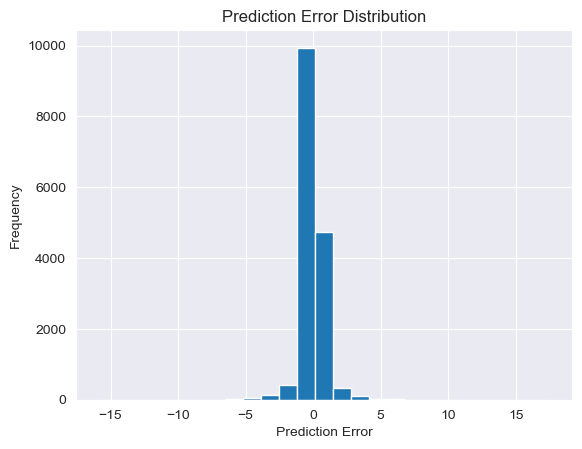

In [25]:
predictions = xgb.predict(X_test)
errors = y_test - predictions

# Plotting error distribution
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()
